# Lecture 8: Ensemble Methods Part 2 (Code used in the slides)

# AdaBoost

In [78]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.ensemble import AdaBoostClassifier

iris = datasets.load_iris()
X, y = iris.data[:, [0, 3]], iris.target   # we only use two features here to make the problem more challenging

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=1)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('Train/Valid/Test sizes:', y_train.shape[0], y_val.shape[0], y_test.shape[0])

Train/Valid/Test sizes: 84 28 38


In [ ]:
tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=1,
                              max_depth=1)    # decision tree stump


boost = AdaBoostClassifier(estimator=tree,    # uses the SAMME algorithm for multi-class classification
                           n_estimators=500,  # we use 500 decision tree stumps
                           #n_jobs=1,         # no parallelism
                           random_state=1)

boost.fit(X_train, y_train)
    
print("Test Accuracy: %0.2f" % boost.score(X_test, y_test))

In [1]:
# boost.estimator_weights_

Let's visualise some of the decision tree stumps that are part of the predictor learnt by Adaboost.

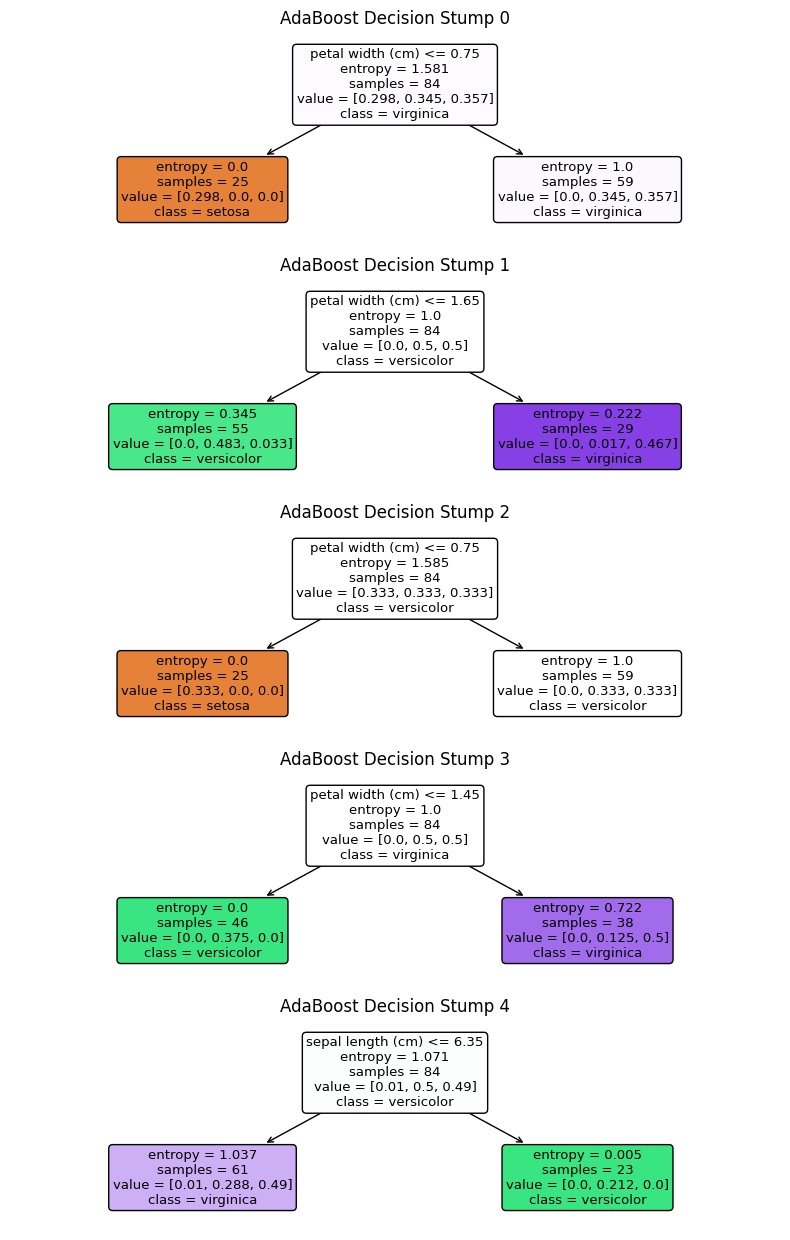

In [4]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Visualise the first 5 trees (or fewer if the model has fewer)
NUM_TREES = 5
n_trees_to_plot = min(NUM_TREES, len(boost.estimators_))

fig, axes = plt.subplots(nrows=n_trees_to_plot, ncols=1, figsize=(8, 2.5 * n_trees_to_plot))

if n_trees_to_plot == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    stump = boost.estimators_[i]
    plot_tree(
        stump,
        feature_names=[iris.feature_names[0], iris.feature_names[3]],
        class_names=iris.target_names,
        filled=True,
        impurity=True,
        rounded=True,
        ax=ax
    )
    ax.set_title(f"AdaBoost Decision Stump {i}")

plt.tight_layout()
plt.show()


# Gradient Boosting

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd

#import ssl
#ssl._create_default_https_context = ssl._create_unverified_context

# Load data with feature names
data = fetch_california_housing(as_frame=True)
X, y = data.data, data.target          # X is a DataFrame; y is a Series
feature_names = data.feature_names

# full DataFrame with target
df = X.copy()
df["target"] = y  # median house value in $100,000s

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Gradient Boosting for REGRESSION 
boost = GradientBoostingRegressor(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=4,
    random_state=1
)

boost.fit(X_train, y_train)

# Evaluate with regression metrics
y_pred = boost.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.3f}")
print(f"Test R^2 : {r2:.3f}")

Test RMSE: 0.506
Test R^2 : 0.807


Initial mean prediction f_0: 2.07035


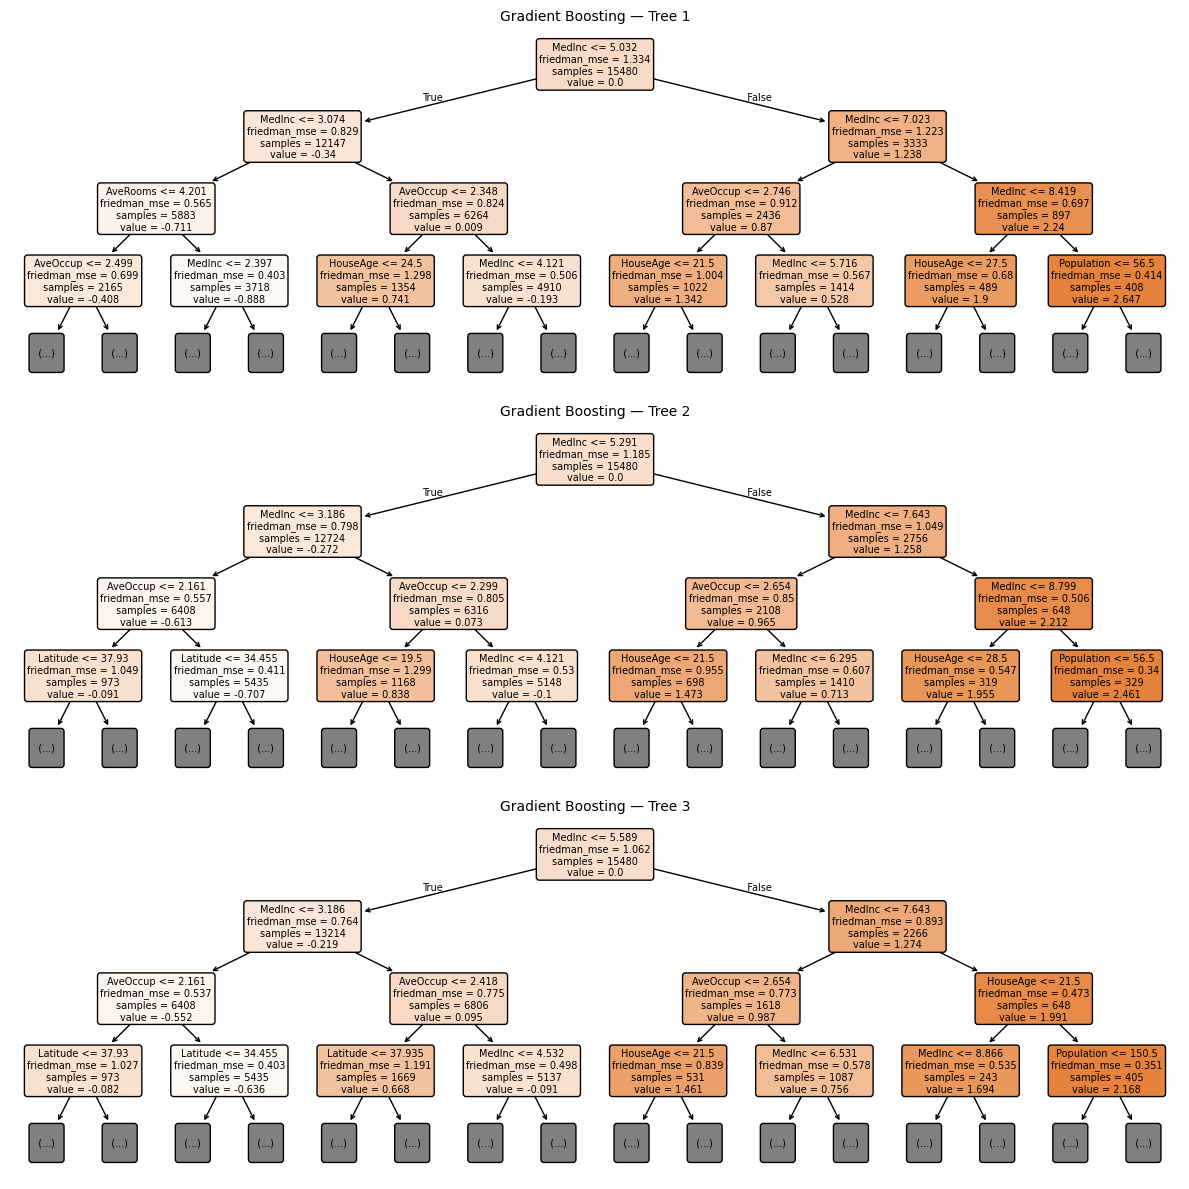

In [13]:
from sklearn import tree
import matplotlib.pyplot as plt
from scipy.special import softmax

F0 = np.mean(y_train)
first_tree = boost.estimators_[0, 0].tree_
root_value = first_tree.value[0].item()

print(f"Initial mean prediction f_0: {F0:.5f}")

# Number of trees to plot
n_trees_to_plot = 3

# Create one column of subplots (vertical layout)
fig, axes = plt.subplots(nrows=n_trees_to_plot, ncols=1, figsize=(12, 4 * n_trees_to_plot))

# If there's only one tree, make sure axes is iterable
if n_trees_to_plot == 1:
    axes = [axes]

# Plot each tree
for i, ax in enumerate(axes):
    tree.plot_tree(
        boost.estimators_[i, 0],
        feature_names=feature_names, # do this to see feature names instead of internal indices
        filled=True,
        rounded=True,
        fontsize=7,
        ax=ax,
        max_depth=3  # optional, limits displayed depth for readability
    )
    ax.set_title(f"Gradient Boosting — Tree {i+1}", fontsize=10)

plt.tight_layout()
plt.show()

In [79]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets

iris = datasets.load_iris()
X, y = iris.data[:, [0, 3]], iris.target #takes columns 0 and 3 (sepal length and petal width)

feature_names = ["sepal length", "petal width"]

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=1)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.25, random_state=1)

print('Train/Valid/Test sizes:', y_train.shape[0], y_val.shape[0], y_test.shape[0])

Train/Valid/Test sizes: 84 28 38


In [80]:
from sklearn.ensemble import GradientBoostingClassifier

boost = GradientBoostingClassifier(
    learning_rate=0.1, # hyperparameters to tune
    n_estimators=100,
    max_depth=4,
    random_state=1)    # except this one

boost.fit(X_train, y_train)
    
print("Test Accuracy: %0.2f" % boost.score(X_test, y_test))

Test Accuracy: 0.95


Let's visualise the the individual decision trees (the weak learners) learnt sequentially by gradient boosting.

Initial class priors: [0.29761905 0.3452381  0.35714286]
Initial constant logits F0 (per class): [-1.21194097 -1.06352097 -1.02961942]


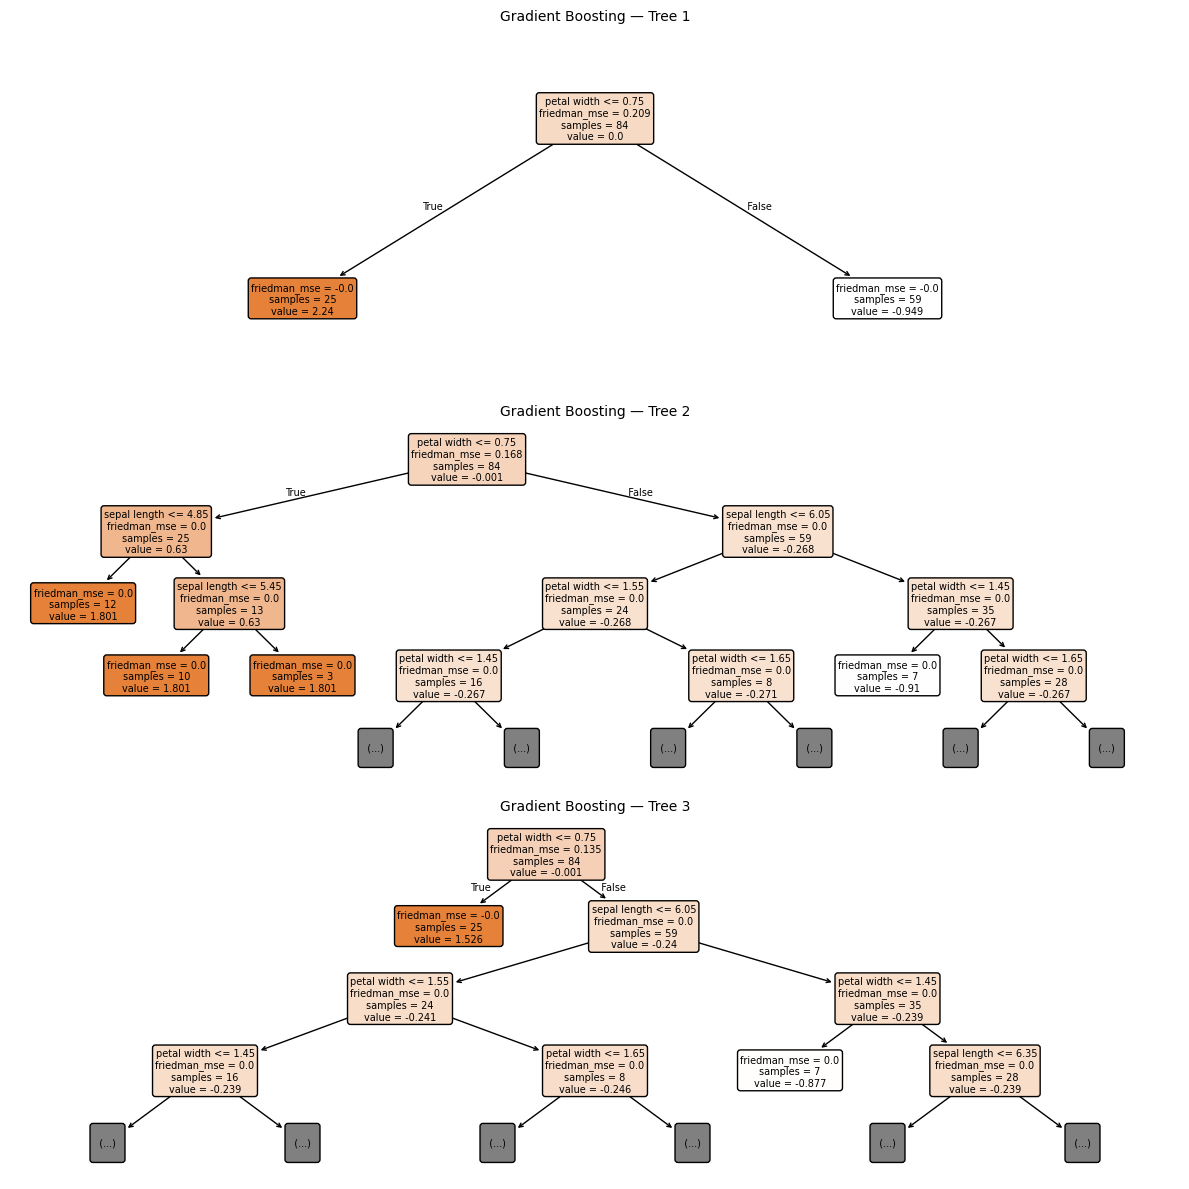

In [86]:
from sklearn import tree
import matplotlib.pyplot as plt
from scipy.special import softmax

priors = boost.init_.class_prior_         

# Print constant in the root node from which gradient boosting starts
print("Initial class priors:", priors)

eps = 1e-12                                 # numerical safety
priors = np.clip(priors, eps, 1 - eps)

# Initial constant logits (one per class), up to an additive constant
F0 = np.log(priors)                         # shape: (K,)

print("Initial constant logits F0 (per class):", F0)

# Number of trees to plot
n_trees_to_plot = 3

# Create one column of subplots (vertical layout)
fig, axes = plt.subplots(nrows=n_trees_to_plot, ncols=1, figsize=(12, 4 * n_trees_to_plot))

# If there's only one tree, make sure axes is iterable
if n_trees_to_plot == 1:
    axes = [axes]

# Plot each tree
for i, ax in enumerate(axes):
    tree.plot_tree(
        boost.estimators_[i, 0],
        feature_names=feature_names, # do this to see feature names instead of internal indices
        filled=True,
        rounded=True,
        fontsize=7,
        ax=ax,
        max_depth=3  # optional, limits displayed depth for readability
    )
    ax.set_title(f"Gradient Boosting — Tree {i+1}", fontsize=10)

plt.tight_layout()
plt.show()


In [25]:
from sklearn.ensemble import HistGradientBoostingClassifier


boost = HistGradientBoostingClassifier(
    learning_rate=0.1,
    #n_estimators=100, # does not have this parameter
    max_depth=8,
    random_state=1)

boost.fit(X_train, y_train)
    
print("Test Accuracy: %0.2f" % boost.score(X_test, y_test))

Test Accuracy: 0.97


In [48]:
from sklearn.ensemble import HistGradientBoostingClassifier

# early_stopping: Instead of blindly training for all 
# 100 iterations, the model monitors its performance 
# on a validation set and halts when it stops improving.
boost_low_lr = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=100,
    early_stopping=True,
    max_depth=8,
    random_state=1)

boost_low_lr.fit(X_train, y_train)
    
print("Test Accuracy: %0.2f" % boost_low_lr.score(X_test, y_test))

boost_low_lr.n_iter_

Test Accuracy: 0.97


52

In [49]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier


boost_high_lr = HistGradientBoostingClassifier(
    learning_rate=0.5, # HIGH learning rate
    max_iter=100,
    early_stopping=True,
    max_depth=8,
    random_state=1)

boost_high_lr.fit(X_train, y_train)
    
print("Test Accuracy: %0.2f" % boost_high_lr.score(X_test, y_test))

boost_high_lr.n_iter_

Test Accuracy: 0.95


100

High learning rate for the second classifier => each tree makes a big jump in the model’s predictions => since every update is large, the validation loss may oscillate => the model appears to keep improving, but validation loss doesn’t plateau smoothly

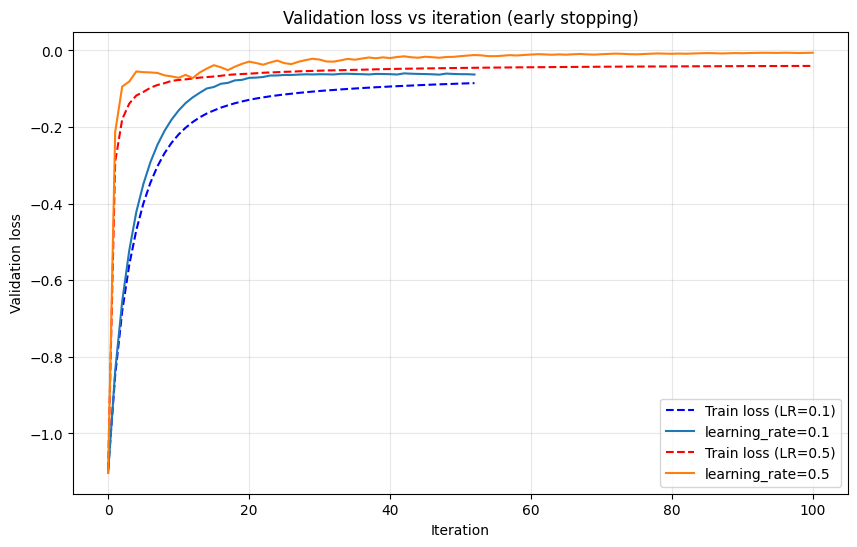

Low LR model stopped after 52 iterations
High LR model stopped after 100 iterations


In [60]:
import matplotlib.pyplot as plt

# Plot validation loss curves
#plt.figure(figsize=(8, 5))
plt.figure(figsize=(10, 6))

plt.plot(boost_low_lr.train_score_, label="Train loss (LR=0.1)", color="blue", linestyle="--")
plt.plot(boost_low_lr.validation_score_, label="learning_rate=0.1")
plt.plot(boost_high_lr.train_score_, label="Train loss (LR=0.5)", color="red", linestyle="--")
plt.plot(boost_high_lr.validation_score_, label="learning_rate=0.5")

plt.xlabel("Iteration")
plt.ylabel("Validation loss")
plt.title("Validation loss vs iteration (early stopping)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print how many iterations each model trained for
print(f"Low LR model stopped after {boost_low_lr.n_iter_} iterations")
print(f"High LR model stopped after {boost_high_lr.n_iter_} iterations")


The following zoomed view makes it visually obvious that:

- For a lower learning rate: smoother, more stable convergence. The validation loss curve flattens smoothly, enabling early stopping.
- For a higher learning rate: noisy, unstable updates that confuse the early stopping criterion. The validation loss curve will wiggle around due to noise. Even if the average loss improves slightly, it never stabilises enough to stop.

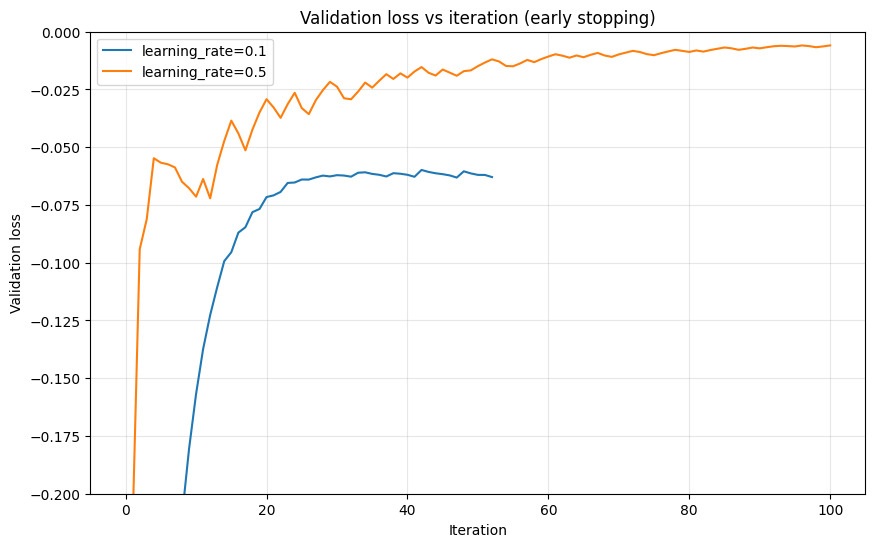

Low LR model stopped after 52 iterations
High LR model stopped after 100 iterations


In [58]:
import matplotlib.pyplot as plt

# Plot validation loss curves
#plt.figure(figsize=(8, 5))
plt.figure(figsize=(10, 6))

plt.plot(boost_low_lr.validation_score_, label="learning_rate=0.1")
plt.plot(boost_high_lr.validation_score_, label="learning_rate=0.5")

plt.xlabel("Iteration")
plt.ylabel("Validation loss")
plt.title("Validation loss vs iteration (early stopping)")
plt.ylim(-0.2, 0.0)   # Zoom in on the y-axis range
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print how many iterations each model trained for
print(f"Low LR model stopped after {boost_low_lr.n_iter_} iterations")
print(f"High LR model stopped after {boost_high_lr.n_iter_} iterations")

In [12]:
# https://xgboost.readthedocs.io/en/latest/build.html

In [7]:
!pip install xgboost


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [31]:
import numpy as np
import xgboost as xgb


dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


param = {
    'max_depth': 8,
    'eta': 0.1,  # learning rate
    'objective': 'multi:softprob',  # loss function for multiclass
    'num_class': 3}  # number of classes

boost = xgb.train(param, dtrain, num_boost_round=100)

y_pred = boost.predict(dtest)
y_labels = np.argmax(y_pred, axis=1)


print("Test Accuracy: %0.2f" % (y_labels == y_test).mean())

Test Accuracy: 0.97


In [45]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

# had to use Data frame to avoid lightgbm warnings
iris = load_iris(as_frame=True)
X = iris.frame[['sepal length (cm)', 'petal width (cm)']]  # cols 0 and 3
y = iris.target

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=1)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.25, random_state=1)

boost = lgb.LGBMClassifier(n_estimators=100, 
                           max_depth=8,
                           random_state=1,
                           learning_rate=0.1, 
                           verbose=-1)

boost.fit(X_train, y_train)

print("Test Accuracy: %0.2f" % boost.score(X_test, y_test))


Test Accuracy: 0.97


# Stacking

In [69]:
iris = datasets.load_iris()
X, y = iris.data[:, [0, 3]], iris.target   # we only use two features here to make the problem more challenging

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.25, random_state=1)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [73]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import StackingClassifier


clf1 = KNeighborsClassifier(n_neighbors=5)
clf2 = RandomForestClassifier(random_state=1)
clf3 = HistGradientBoostingClassifier(random_state=1)
clf4 = AdaBoostClassifier(random_state=1)
clf5 = DecisionTreeClassifier(random_state=1,
                              max_depth=None)

lr = LogisticRegression(random_state=1)

estimators = [('clf1', clf1),
              ('clf2', clf2),
              ('clf3', clf3),
              ('clf4', clf4),
              ('clf5', clf5)]

sclf = StackingClassifier(estimators=estimators, 
                          final_estimator=lr, 
                          cv=10)  # 10-fold cross-validation, the default is 5


sclf.fit(X_train, y_train)
print("Train Accuracy: %0.2f" % sclf.score(X_train, y_train))
print("Test Accuracy: %0.2f" % sclf.score(X_test, y_test))

Train Accuracy: 0.98
Test Accuracy: 0.95
